In [1]:
import sys
import numpy as np
from array import array
import matplotlib
import matplotlib.pyplot as plt
import time
import copy
from scipy import interpolate
import matplotlib.colors as colors
import uproot
uproot.__version__

%matplotlib inline

#font = {'family' : 'DejaVu Sans',
#        'weight' : 'normal',
#        'size'   : 16}

#plot_geo={'num':None, 
#         'figsize':(8, 6),
#         'dpi':500, 
#         'facecolor':'w',
#         'edgecolor':'k'}
#matplotlib.rcParams['figure.figsize'] = (20, 10)

#matplotlib.matplotlib_fname() #shows location of rcParams file

In [2]:
f_rn222 = uproot.open('root_files/high_stats/data_Rn222_100bin.root')
f_b8 = uproot.open('root_files/high_stats/data_B8_100bin.root')
hname = 'h_S1logS2'
print(f_rn222.keys())

h_rn222 = f_rn222[hname]
h_b8 = f_b8[hname]

['NESTree;1', 'f_background;1', 'h_S1logS2;1', 'w_config;1', 'ProcessID0;1', 'h_lowstat;1']


In [3]:
#print(h_rn222.values())
#print(h_rn222.bins)
#print( h_rn222.axis(0).edges() )
#print( h_rn222.axis(1).edges() )
h_rn222.axis(1).edges()[-1]

5.5

In [4]:
#basic functions
def get_bin_centers(h):
    x = h.axis(0).edges()
    y = h.axis(1).edges()
    xbin_c = 0.5 * (x[1:] + x[:-1])
    ybin_c = 0.5 * (y[1:] + y[:-1])
    return xbin_c, ybin_c

def get_bin_widths(h):
    #only works for uniform binning
    x = h.axis(0).edges()
    y = h.axis(1).edges()
    xbw = (x[-1]-x[0])/(len(x)-1) 
    ybw = (y[-1]-y[0])/(len(y)-1)
    return xbw, ybw

def build_pdf(h): #returns normalized pdf
    vals = h.values()
    pdf = vals / np.sum(vals)
    return pdf

def build_cdf(h):
    pdf = build_pdf(h)
    cdf = np.cumsum(pdf.ravel(order="F"))
    cdf = cdf / cdf[-1]
    return cdf


In [5]:
# function to get nsamples from the distribution (based on Xin's code)

def generate_observables_2d(h, n_samples=1, interp_order=0):
    """
    Randomly sample (x1, x2) from pdf
    Output: ndarray, shape = (2, n_samples)
    Note:
        Algotrhim is the same as TH2::GetRandom2(),
        unravel_index(..., order="F") means fortain style. Must be the same
        as ravel(..., order="F")
    """
    hist_val = build_pdf(h)
    cdf = build_cdf(h)
    hist_x1, hist_x2 = get_bin_centers(h)

    r_val = np.random.rand(n_samples)
    ibin = np.searchsorted(cdf, r_val)
    hist_shape = hist_val.shape
    x1_idx, x2_idx = np.unravel_index(ibin, hist_shape, order="F") #for uproot3 need "F"
    if interp_order == 0:
        return hist_x1[x1_idx], hist_x2[x2_idx]
    else:
        x1_bw, x2_bw = get_bin_widths(h)
        x1_new = hist_x1[x1_idx] - x1_bw / 2.0  # lower edge
        x2_new = hist_x2[x2_idx] - x2_bw / 2.0  # lower edge
        x1_delta = (r_val - cdf[ibin - 1]) * x1_bw / (cdf[ibin] - cdf[ibin - 1])
        mask = r_val > cdf[ibin - 1]
        np.place(x1_new, mask, x1_new[mask] + x1_delta[mask])
        x2_new += x2_bw * np.random.rand(n_samples)
        return x1_new, x2_new

In [6]:
    def bilinear_interpolation(hist, data):
        """
        Method: Bilinear Interpolation, same algothrom as TH2:Interpolate
        https://en.wikipedia.org/wiki/Bilinear_interpolation
        (this is suppose to be faster than interp2d and griddata)
        Input:
            data: ndarray. shape = (2, n_samples)
            bkg_index: int
        Output:
            1d array
        """
        
        hist_val = build_pdf(hist)
        hist_x1, hist_x2 = get_bin_centers(hist)
        x1_bw, x2_bw = get_bin_widths(hist)
        
        x1 = data[0]
        x2 = data[1]
        x1_l_idx = np.array((x1 - hist_x1[0]) / x1_bw, dtype=int)
        x2_l_idx = np.array((x2 - hist_x2[0]) / x2_bw, dtype=int)
        x1_h_idx = x1_l_idx + 1
        x2_h_idx = x2_l_idx + 1
        q11 = hist_val[x1_l_idx, x2_l_idx]
        q12 = hist_val[x1_l_idx, x2_h_idx]
        q21 = hist_val[x1_h_idx, x2_l_idx]
        q22 = hist_val[x1_h_idx, x2_h_idx]
        x1_l = hist_x1[x1_l_idx]
        x1_h = hist_x1[x1_h_idx]
        x2_l = hist_x2[x2_l_idx]
        x2_h = hist_x2[x2_h_idx]

        return (
            q11 * (x1_h - x1) * (x2_h - x2)
            + q21 * (x1 - x1_l) * (x2_h - x2)
            + q12 * (x1_h - x1) * (x2 - x2_l)
            + q22 * (x1 - x1_l) * (x2 - x2_l)
        ) / ((x1_h - x1_l) * (x2_h - x2_l) + 0.0)
    
    def calc_event_prob(hist, data, interp_order=0):
        """
        calcualte Prob(x1,x2...) from a PDF
        Input:
            data: ndarray. shape = (2, n_samples)
            bkg_index: int
        Output:
            1d array
        Note: use bkg_index=-1 for signal PDF
        """
        if interp_order == 0:
            hist_val = build_pdf(hist)
            x1 = data[0]
            x2 = data[1]
            #print(x1,x2)
            x1_bw, x2_bw = get_bin_widths(hist)
            x1_idx = np.array((x1 - x1_bw / 2.0 - hist.axis(0).edges()[0]) / x1_bw + 0.5, dtype=int)
            x2_idx = np.array((x2 - x2_bw / 2.0 - hist.axis(1).edges()[0]) / x2_bw + 0.5, dtype=int)
            return hist_val[x1_idx, x2_idx]
        else:
            return bilinear_interpolation(hist, data)

In [7]:
def estimate_contours(hist, levels):
    """
    hist: uproot histogram
    levels: np array of levels, ex: (0.68, 0.95, 0.997)
    """
    nsamples = 10000000
    pdf_vals = calc_event_prob(hist, generate_observables_2d(hist, nsamples, 0), 0)
    probs = 1-levels
    return np.quantile(pdf_vals, probs)

In [8]:
x1_bin_c, x2_bin_c = get_bin_centers(h_rn222)
x1_bin_w, x2_bin_w = get_bin_widths(h_rn222)
print(x1_bin_w, x2_bin_w)
#vals = h_rn222.values()/np.sum(h_rn222.values())
pdf_rn222 = build_pdf(h_rn222)
pdf_b8 = build_pdf(h_b8)

0.8 0.03


In [9]:
#hist_val = build_pdf(h_rn222)
#data = np.array([[10.1,11],[4.,4.1]])
#x1 = data[0]
#x2 = data[1]
#print(x1,x2)
#x1_bw, x2_bw = get_bin_widths(h_rn222)
#x1_idx = np.array((x1 - x1_bw / 2.0 - h_rn222.axis(0).edges()[0]) / x1_bw + 0.5, dtype=int)
#x2_idx = np.array((x2 - x2_bw / 2.0 - h_rn222.axis(1).edges()[0]) / x2_bw + 0.5, dtype=int)
#x1_idx = np.array((x1 - h_rn222.axis(0).edges()[0]) / x1_bw , dtype=int)
#x2_idx = np.array((x2 - h_rn222.axis(1).edges()[0]) / x2_bw , dtype=int)
#print(x1_idx, x2_idx)

In [10]:
calc_event_prob(h_rn222, generate_observables_2d(h_rn222, 2, 0) ,0)


array([0.00118621, 0.00085474])

In [11]:
#make some same data:
xdata, ydata = generate_observables_2d(h_rn222, 1000, 1)

In [12]:
cont_levels_rn222 = estimate_contours(h_rn222, np.array([0.68,0.95,0.997]))
cont_levels_b8 = estimate_contours(h_b8, np.array([0.68,0.95,0.997]))
print(cont_levels_rn222)

[7.24462515e-04 1.68631135e-04 1.44747755e-05]


In [15]:
np.min(Z_rn222[Z_rn222>0])

7.237387766209215e-07

[1.4474775532418431e-05, 0.0001686311349526747, 0.0007244625153975424, 0.0014424113818054965]


<ipython-input-13-e3d9b6089661>:17: UserWarning: Log scale: values of z <= 0 have been masked
  cf_rn222 = ax.contourf(X_rn222, Y_rn222, Z_rn222, levels_t, cmap=cmap, alpha=0.5, extend='neither', norm=colors.LogNorm(vmin=levels_t[0], vmax=Z_rn222.max()))
<ipython-input-13-e3d9b6089661>:33: UserWarning: Log scale: values of z <= 0 have been masked
  cf_b8 = ax.contourf(X_b8, Y_b8, Z_b8, levels_t2, cmap=rcmap, alpha=0.5, extend='neither', norm=colors.LogNorm(vmin=levels_t2[0], vmax=Z_b8.max()))


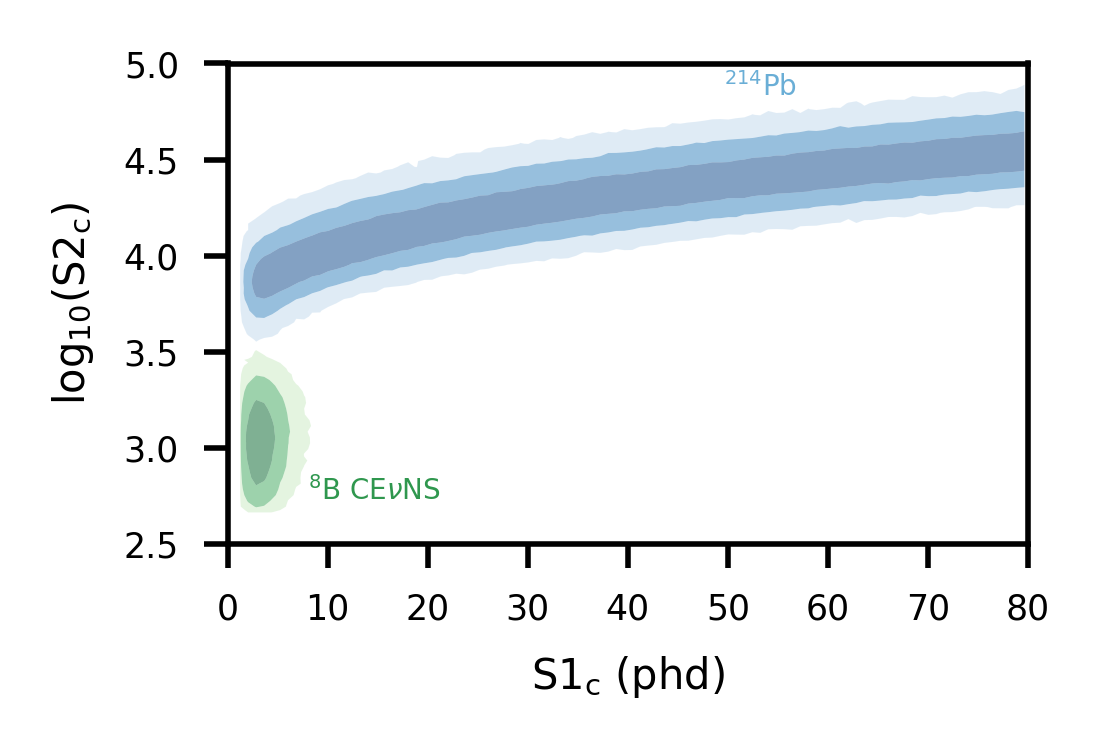

In [13]:
# make a contour-ish plot

x_rn222, y_rn222 = get_bin_centers(h_rn222)
X_rn222, Y_rn222 = np.meshgrid(x_rn222,y_rn222)
Z_rn222 = pdf_rn222.T

#levels_t = [np.min(Z_rn222[Z_rn222>0])] + np.sort(cont_levels_rn222).tolist()
levels_t = np.sort(cont_levels_rn222).tolist()
levels_t.append(Z_rn222.max()) #set highest level to be max so only colors below show up

print(levels_t)

fig = plt.figure(figsize=(2.3,1.6),dpi=500)
ax = fig.gca()

cmap = plt.cm.Blues
cf_rn222 = ax.contourf(X_rn222, Y_rn222, Z_rn222, levels_t, cmap=cmap, alpha=0.5, extend='neither', norm=colors.LogNorm(vmin=levels_t[0], vmax=Z_rn222.max()))
for c in cf_rn222.collections:
    c.set_edgecolor('face')
    c.set_linewidth(0.00000000000001)
    
###################################
# Boron 8

x_b8, y_b8 = get_bin_centers(h_b8)
X_b8, Y_b8 = np.meshgrid(x_b8,y_b8)
Z_b8 = pdf_b8.T

levels_t2 = np.sort(cont_levels_b8).tolist()
levels_t2.append(Z_b8.max()) #set highest level to be max so only colors below show up

rcmap = plt.cm.Greens
cf_b8 = ax.contourf(X_b8, Y_b8, Z_b8, levels_t2, cmap=rcmap, alpha=0.5, extend='neither', norm=colors.LogNorm(vmin=levels_t2[0], vmax=Z_b8.max()))
for c in cf_b8.collections:
    c.set_edgecolor('face')
    c.set_linewidth(0.00000000000001)

#----------------------------------------------------------------------------
ax.set_xlabel(r'S1$_{\rm c}$ (phd)',fontsize=6)
ax.set_ylabel(r'log$_{10}$(S2$_{\rm c}$)',fontsize=6)

xmin=0
xmax=80
ymin=2.5
ymax=5
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.tick_params(axis='both', which='major', labelsize=5)

ytickstep = 0.5
xtickstep = 10
ax.xaxis.set_ticks(np.arange(xmin, xmax+xtickstep, xtickstep))
ax.yaxis.set_ticks(np.arange(ymin, ymax+ytickstep, ytickstep))

plt.text(0.62, 0.95, r'$^{214}$Pb',fontsize=4,color=cmap(0.5),horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
plt.text(0.1, 0.11, r'$^{8}$B CE$\nu$NS',fontsize=4,color=rcmap(0.7),horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

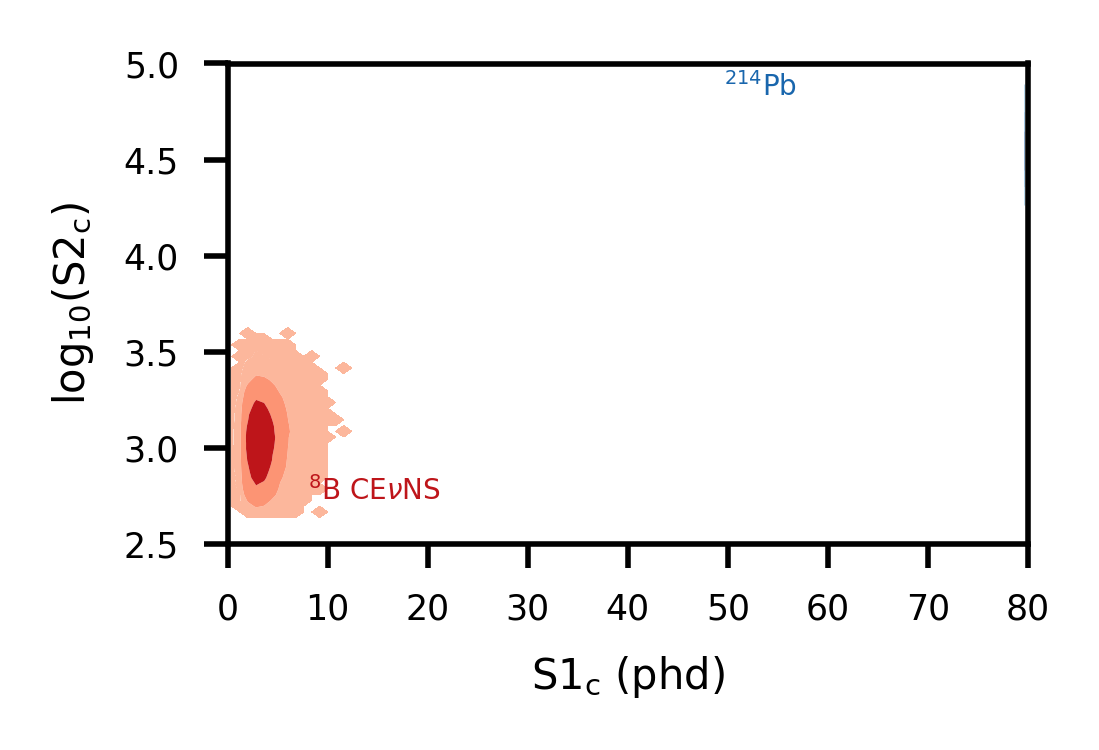

In [16]:
# make a contour-ish plot

x_rn222, y_rn222 = get_bin_centers(h_rn222)
X_rn222, Y_rn222 = np.meshgrid(x_rn222,y_rn222)
Z_rn222 = pdf_rn222.T

x_b8, y_b8 = get_bin_centers(h_b8)
X_b8, Y_b8 = np.meshgrid(x_b8,y_b8)
Z_b8 = pdf_b8.T

fig = plt.figure(figsize=(2.3,1.6),dpi=500)
ax = fig.gca()

#print('{:0.2e}'.format(Z.max()))

levels_rn222 = np.sort(cont_levels_rn222).tolist()
levels_rn222.append(Z_rn222.max()) #set highest level to be max so only colors below show up
#cmap = copy.copy(plt.cm.get_cmap('Blues')) #this line copies the color map and avoids a warning
cmap = plt.cm.Blues(np.linspace(0,1,20))
cmap = colors.ListedColormap(cmap[10:,:-1])
cmap.set_under('white')
cmap.set_over('yellow')
cf_rn222 = ax.contourf(X_rn222, Y_rn222, Z_rn222, levels_rn222, cmap=cmap, alpha=1, extend='both') #n_colors should = len(levels)-1 #colors=('r', 'g', 'b'),

#CS3.cmap.set_under('white')
#CS3.cmap.set_over('yellow')

# This is the fix for the white lines between contour levels
for c in cf_rn222.collections:
    c.set_edgecolor('face')
    c.set_linewidth(0.00000000000001)
plt.text(0.62, 0.95, r'$^{214}$Pb',fontsize=4,color=cmap(0.5),horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)

# boron-8
levels_b8 = np.sort(cont_levels_b8).tolist()
levels_b8.append(Z_b8.max()) #set highest level to be max so only colors below show up
levels_b8 = [0] + levels_b8
#cmap = copy.copy(plt.cm.get_cmap('Blues')) #this line copies the color map and avoids a warning
rcmap = plt.cm.Reds(np.linspace(0,1,20))
rcmap = colors.ListedColormap(rcmap[5:,:-1])
rcmap.set_under('white')
rcmap.set_over('yellow')
cf_b8 = ax.contourf(X_b8, Y_b8, Z_b8, levels_b8, cmap=rcmap, alpha=1, extend='both') #n_colors should = len(levels)-1 #colors=('r', 'g', 'b'),
for c in cf_b8.collections:
    c.set_edgecolor('face')
    c.set_linewidth(0.00000000000001)

plt.text(0.1, 0.11, r'$^{8}$B CE$\nu$NS',fontsize=4,color=rcmap(0.7),horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)

#fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
#fmt.set_powerlimits((0, 0))
#cbar = fig.colorbar(CS3,format=fmt)
#cbar = fig.colorbar(CS3,format='%0.2e')
#cbar.ax.tick_params(labelsize=3)

# contours as lines:
#CS4 = ax.contour(X, Y, Z, levels, colors=('k',), linewidths=(0.2,))
#ax.clabel(CS4, fmt='%2.1e', colors='k', fontsize=1)

#----------------------------------------------------------------------------
ax.set_xlabel(r'S1$_{\rm c}$ (phd)',fontsize=6)
ax.set_ylabel(r'log$_{10}$(S2$_{\rm c}$)',fontsize=6)

xmin=0
xmax=80
ymin=2.5
ymax=5
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.tick_params(axis='both', which='major', labelsize=5)

ytickstep = 0.5
xtickstep = 10
ax.xaxis.set_ticks(np.arange(xmin, xmax+xtickstep, xtickstep))
ax.yaxis.set_ticks(np.arange(ymin, ymax+ytickstep, ytickstep))

plt.tight_layout()
plt.show()

#plt.savefig('/Users/Scott/Downloads/contour_test.pdf')

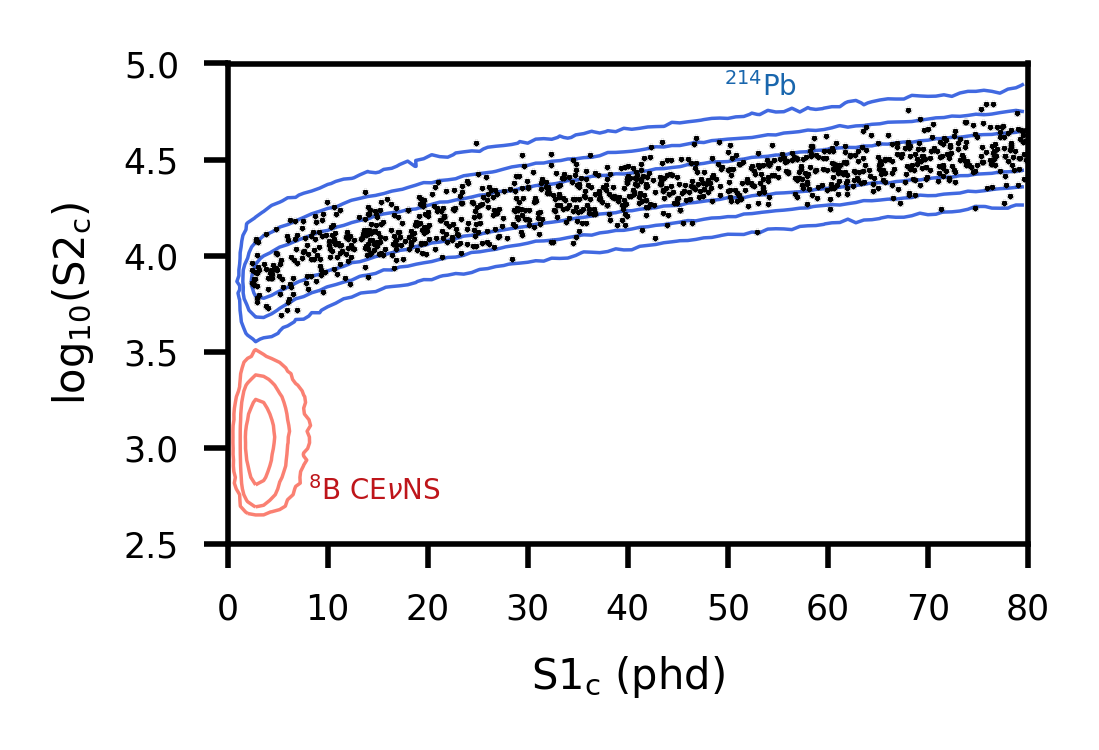

In [14]:
# make a contour-ish plot

fig = plt.figure(figsize=(2.3,1.6),dpi=500)
ax = fig.gca()

ax.contour(X_rn222, Y_rn222, Z_rn222, levels_rn222[:-1],linewidths=(0.5,),colors=('royalblue',))
plt.text(0.62, 0.95, r'$^{214}$Pb',fontsize=4,color=cmap(0.5),horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)

# boron-8
ax.contour(X_b8, Y_b8, Z_b8, levels_b8[:-1],linewidths=(0.5,),colors=('salmon',))
plt.text(0.1, 0.11, r'$^{8}$B CE$\nu$NS',fontsize=4,color=rcmap(0.7),horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)

plt.plot(xdata,ydata,color='black',marker='*',markersize=0.25,linestyle='none',linewidth=0)


#----------------------------------------------------------------------------
ax.set_xlabel(r'S1$_{\rm c}$ (phd)',fontsize=6)
ax.set_ylabel(r'log$_{10}$(S2$_{\rm c}$)',fontsize=6)

xmin=0
xmax=80
ymin=2.5
ymax=5
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.tick_params(axis='both', which='major', labelsize=5)

ytickstep = 0.5
xtickstep = 10
ax.xaxis.set_ticks(np.arange(xmin, xmax+xtickstep, xtickstep))
ax.yaxis.set_ticks(np.arange(ymin, ymax+ytickstep, ytickstep))

plt.tight_layout()
plt.show()

#plt.savefig('/Users/Scott/Downloads/contour_test.pdf')

In [2]:
area = 12.2
print('pulse area = {:0.2e}'.format(area))

pulse area = 1.22e+01


In [9]:
#with np.printoptions(threshold=np.inf):
#print( vals[:,150] )

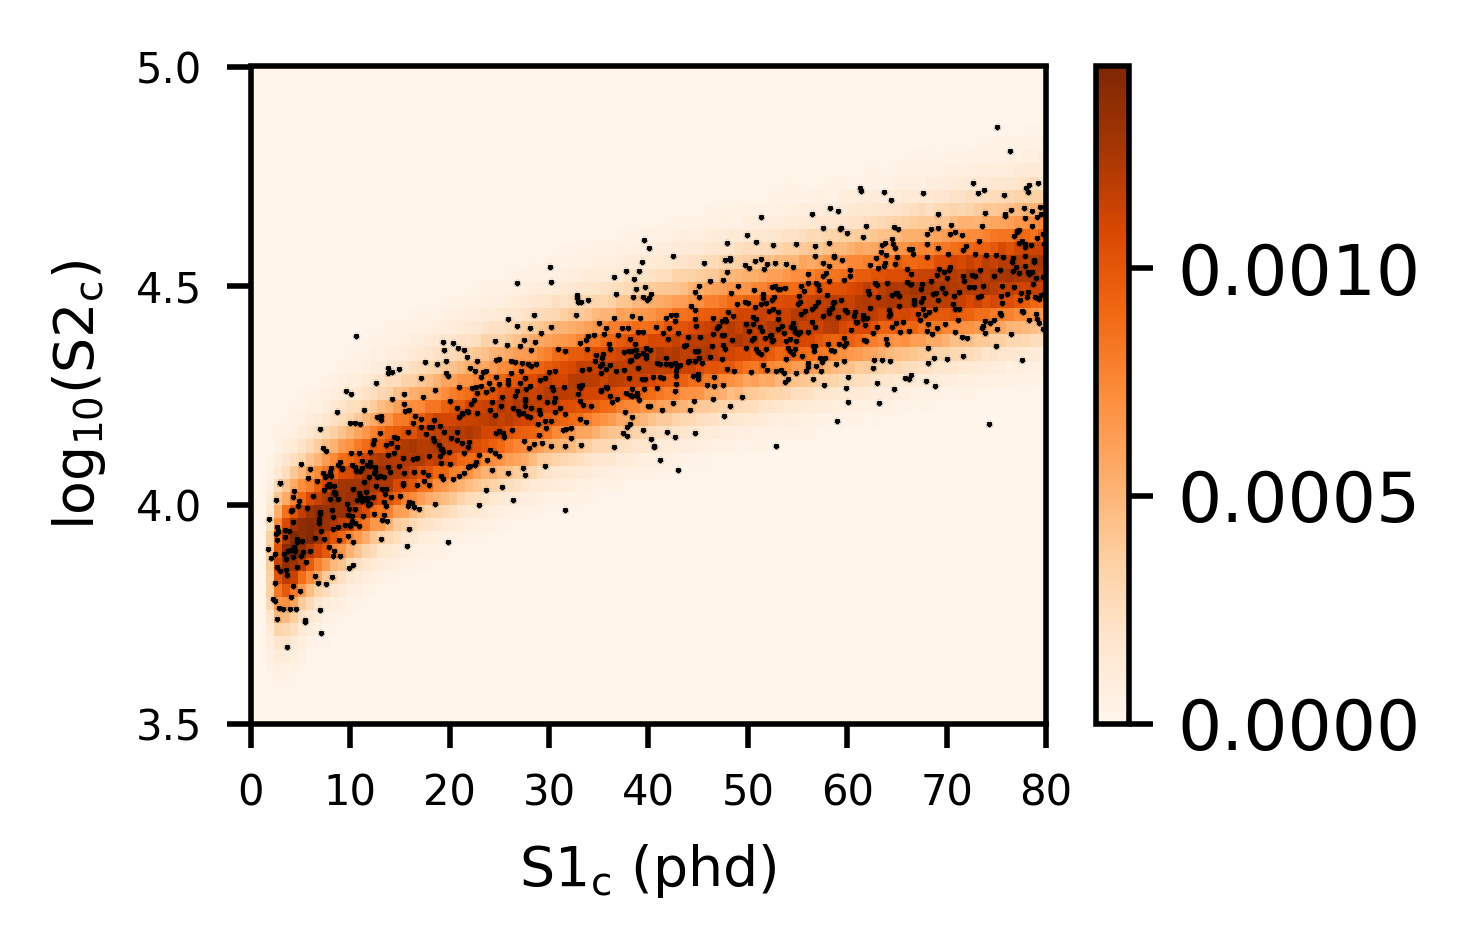

In [29]:
# make the plot

fig = plt.figure(figsize=(3,2),dpi=500)
ax = fig.gca()
plt.pcolormesh(X, Y, Z_rn222, vmin=Z_rn222.min(), vmax=Z_rn222.max(),shading='nearest',cmap='Oranges',snap=False) #must use shading='nearest' if x&y give the bin centers!
plt.colorbar()
#level = np.linspace(np.min(Z_sig), np.max(Z_sig), 6)[1:-1]
#plt.contour(x,y,Z, cont_levels, colors='black')

plt.plot(xdata,ydata,color='black',marker='*',markersize=0.25,linestyle='none',linewidth=0)

ax.set_xlabel(r'S1$_{\rm c}$ (phd)',fontsize=8)
ax.set_ylabel(r'log$_{10}$(S2$_{\rm c}$)',fontsize=8)

xmin=0
xmax=80
ymin=3.5
ymax=4.7
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.tick_params(axis='both', which='major', labelsize=6)

ytickstep = 0.5
xtickstep = 10
ax.xaxis.set_ticks(np.arange(xmin, xmax+xtickstep, xtickstep))
ax.yaxis.set_ticks(np.arange(ymin, ymax+ytickstep, ytickstep))

plt.tight_layout()

#plt.savefig('/Users/Scott/Downloads/contour_test.pdf')

In [63]:
levels = np.linspace(np.min(Z_sig), np.max(Z_sig), 6)[1:-1]
print(levels)

[1.06854743 2.13709486 3.20564229 4.27418972]


In [ ]:
def pdf_contour(x,y,nsamples=1e4,nsig=2,color='b',fill=True,fill_alpha=0.2,\
                colormap=plt.cm.Reds, bins=50,label=True, lw=2, line_alpha=1,\
                zorder=1):
    '''Return contour levels'''
    if(len(x)>nsamples):
        rnd_index=np.random.choice(np.arange(0,len(x)),int(nsamples))
        x=x[rnd_index]
        y=y[rnd_index]
    xmin = min(x)
    xmax = max(x)
    ymin = min(y)
    ymax = max(y)
    x_range = np.linspace(xmin,xmax,bins)
    y_range = np.linspace(ymin,ymax,bins)
    pdf_kde = st.kde.gaussian_kde([x,y])
    
    # sample the pdf and find the value at different percentiles
    # nsamples=5000
    nsamples = int(nsamples)
    #to have a contour that contains X% of probability, I need the
    #(1-X)-th percentile
    sig1=np.percentile(pdf_kde(pdf_kde.resample(nsamples)), 100-68.27)
    sig2=np.percentile(pdf_kde(pdf_kde.resample(nsamples)), 100-95.44)
    sig3=np.percentile(pdf_kde(pdf_kde.resample(nsamples)), 100-99.73)
    q50=np.percentile(pdf_kde(pdf_kde.resample(nsamples)), 50.)
    q0=np.percentile(pdf_kde(pdf_kde.resample(nsamples)), 100-0.)
    # print sig1, sig2, sig3
    # print q0, q50

    levels=[sig1,sig2,sig3][:nsig]
    levels.reverse()#levels must be in increasing order
    linestyles=['-','-',':'][:nsig]
    linestyles.reverse()
    
    # Plot contour lines
    xi,yi = np.meshgrid(x_range, y_range)
    Z = pdf_kde([xi.flatten(),yi.flatten()])
    Z = Z.reshape(len(y_range),len(x_range))
    CS=plt.contour(x_range, y_range, Z, levels, linewidths=lw, alpha=line_alpha,\
                   colors=color, linestyles=linestyles, zorder=zorder)
    
    if fill==True:
        levels.append(q0) #Filled contours require at least 2 levels
        # levels.reverse() #bring 10 to the beginning
        plt.contourf(x_range, y_range, Z, levels, alpha=fill_alpha,cmap=colormap,\
                     zorder=zorder)
    if label==True:
        CS.levels = ['1$\sigma$','2$\sigma$','3$\sigma$'][:nsig]
        CS.levels.reverse()#levels must be in increasing order
        plt.clabel(CS, CS.levels, inline=True, fontsize=20)

    return

In [ ]:
vals = range(n_t1s)
cmap = plt.get_cmap('Oranges')
#cmap = sns.cubehelix_palette(n_colors=5,rot=-.5,as_cmap=True)
#cmap = sns.cubehelix_palette(n_colors=6,start=6, rot=-0.3, dark=0.3, light=0.9, as_cmap=True)
cNorm  = colors.Normalize(vmin=-1, vmax=vals[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

#colors = ['#86E5BB','#65CAC8','#44AFD4','#2393E1','#0278ED']

lw = 1.2

ax.axhline(100, linestyle='--',linewidth=0.5,color='gray')

#lines at the state lifetimes
ax.axvline(state_time_4p, linestyle='--',linewidth=0.5,color='lightgray')
ax.axvline(state_time_3p, linestyle='--',linewidth=0.5,color='lightgray')

for ii in range(n_t1s):
    if t1s[ii] < 6.0:
        label_str = r'$t_1={:0.1f}\,\mu$s'.format(t1s[ii])
    else:
        label_str = r'$t_1={:0.0f}\,\mu$s'.format(t1s[ii])
    
    colorVal = scalarMap.to_rgba(vals[ii])
    plt.plot(tau_array,eff_array[:,ii],color=colorVal,linestyle='-',linewidth=lw,label=label_str)




In [33]:
import ROOT

Welcome to JupyROOT 6.22/02


In [34]:
file1 = ROOT.TFile.Open('root_files/data_wimp_background_B8.root')
h_b8 = file1.Get('h_S1logS2')
h_b8.SetName('h_b8')
#file1.Close()

file2 = ROOT.TFile.Open('root_files/data_wimp_background_Rn222.root')
h_rn = file2.Get('h_S1logS2')
h_rn.SetName('h_rn')


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


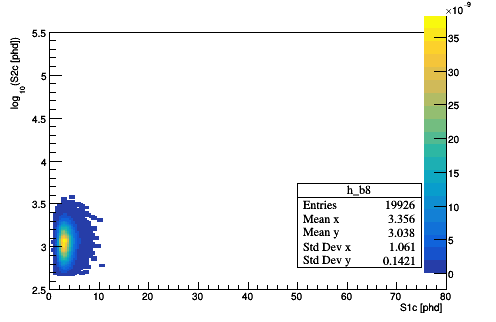

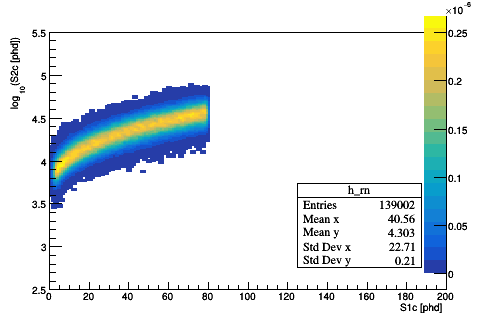

In [15]:
c = ROOT.TCanvas('c','c',500,350)
h_b8.Draw('colz')
c.Draw()

c2 = ROOT.TCanvas('c2','c2',500,350)
h_rn.Draw('colz')
c2.Draw()

In [18]:
ws_file = ROOT.TFile.Open('root_files/workspace_WIMP_mass_40.0_SI.root')
w = ws_file.Get('w')
#w.Print()

In [ ]:
def estimateContours(pdf, obs, levels)
    
    # pdf: a RooAbsPdf
    # obs: RooArgSet
    # levels: array of desired prob content. e.g. 0.68, 0.95, 0.997
    
    #contours at a certain level can be estimated by computing the pdf value
    #at randomly generated points and taking quantiles of that distribution
    vector<double> pdfLevels = vector(levels.size(), 0.);
    vector<double> invLevel;
    for (auto probi : levels) {
        invLevel.push_back(1. - probi);
    }
    auto ds = pdf->generate(*obs, 1e6);
    ds->addColumn(*pdf);

    auto hist = (TH1D*)ds->createHistogram(pdf->GetName(), 1000);
    #hist->Print();
    #cout << hist->GetMaximum() << "\t" <<
    #hist->GetBinCenter(hist->GetNbinsX()) << endl;
    hist->GetQuantiles(levels.size(), pdfLevels.data(), invLevel.data());
    if (levels[0] == 0) {
        pdfLevels[0] = hist->GetBinCenter(hist->GetNbinsX());
    }

    #cleanup
    delete ds;
    delete hist;

    return pdfLevels

In [2]:
# load in raw limit data
# data format: 
# mass [GeV], integrated signal flux times exposure, X% CL upper limit on the POI, median expectation,
# -1sig expectation, +1sig expectation, -2sig expectation, +2sig expectation, exposure [kg*day]

#mdc3 = np.loadtxt('./mdc3_mu-5_fix.txt',dtype=float)
mdc3 = np.loadtxt('./mdc3_mu_positive_twosided.txt',dtype=float)
sens_paper = np.loadtxt('./senspaper.txt',dtype=float,skiprows=1,usecols=(0,1))

n_masses = np.size(mdc3,0)

print(n_masses)
print(np.shape(mdc3))
print(np.shape(sens_paper))

22
(22, 9)
(14, 2)


In [3]:
# load in raw limit data for mu>0
# data format: 
# mass [GeV], integrated signal flux times exposure, X% CL upper limit on the POI, median expectation,
# -1sig expectation, +1sig expectation, -2sig expectation, +2sig expectation, exposure [kg*day]

mdc3_pos = np.loadtxt('./mdc3_mu_positive_onesided.txt',dtype=float)

In [4]:
# extract limit in cm^2
zb_to_cm2 = 1e-45

obs_mdc3 = np.zeros((n_masses,2))
exp_mdc3 = np.zeros((n_masses,2))
fc = np.zeros((n_masses,2))

nexcld = np.zeros((n_masses,2))
nexcld_exp = np.zeros((n_masses,2))

obs_mdc3_pos = np.zeros((n_masses,2))
exp_mdc3_pos = np.zeros((n_masses,2))

# mass dimension:
#obs_mdc3[:,0] = np.copy( mdc3[:,0] )
#exp_mdc3[:,0] = np.copy( mdc3[:,0] )

fc_nexcld = 4.045/0.5

# limits:
for i in range(n_masses):
    #print(mdc3[i,0])
    obs_mdc3[i,0] = mdc3[i,0]
    exp_mdc3[i,0] = mdc3[i,0]
    obs_mdc3[i,1] = (mdc3[i,2]/mdc3[i,1])*zb_to_cm2
    exp_mdc3[i,1] = (mdc3[i,3]/mdc3[i,1])*zb_to_cm2
    
    obs_mdc3_pos[i,0] = mdc3_pos[i,0]
    exp_mdc3_pos[i,0] = mdc3_pos[i,0]
    obs_mdc3_pos[i,1] = (mdc3_pos[i,2]/mdc3_pos[i,1])*zb_to_cm2
    exp_mdc3_pos[i,1] = (mdc3_pos[i,3]/mdc3_pos[i,1])*zb_to_cm2
    
    fc[i,0] = mdc3[i,0]
    fc[i,1] = (fc_nexcld/mdc3[i,1])*zb_to_cm2
    
    nexcld[i,0] = mdc3[i,0]
    nexcld[i,1] = mdc3[i,2]
    nexcld_exp[i,0] = mdc3[i,0]
    nexcld_exp[i,1] = mdc3[i,3]


In [5]:
#sens_interp = interpolate.interp1d( sens_paper[:,0], sens_paper[:,1], kind='linear')#, kind='linear'
#new_masses = np.copy( obs_mdc3[:,0] )
#new_senspaper = sens_interp( new_masses )

In [6]:
sens_interp = interpolate.interp1d(np.log10(sens_paper[:,0]), np.log10(sens_paper[:,1]), kind='linear')
new_masses = np.copy( obs_mdc3[:,0] )
new_senspaper = 10**sens_interp( np.log10(new_masses) )

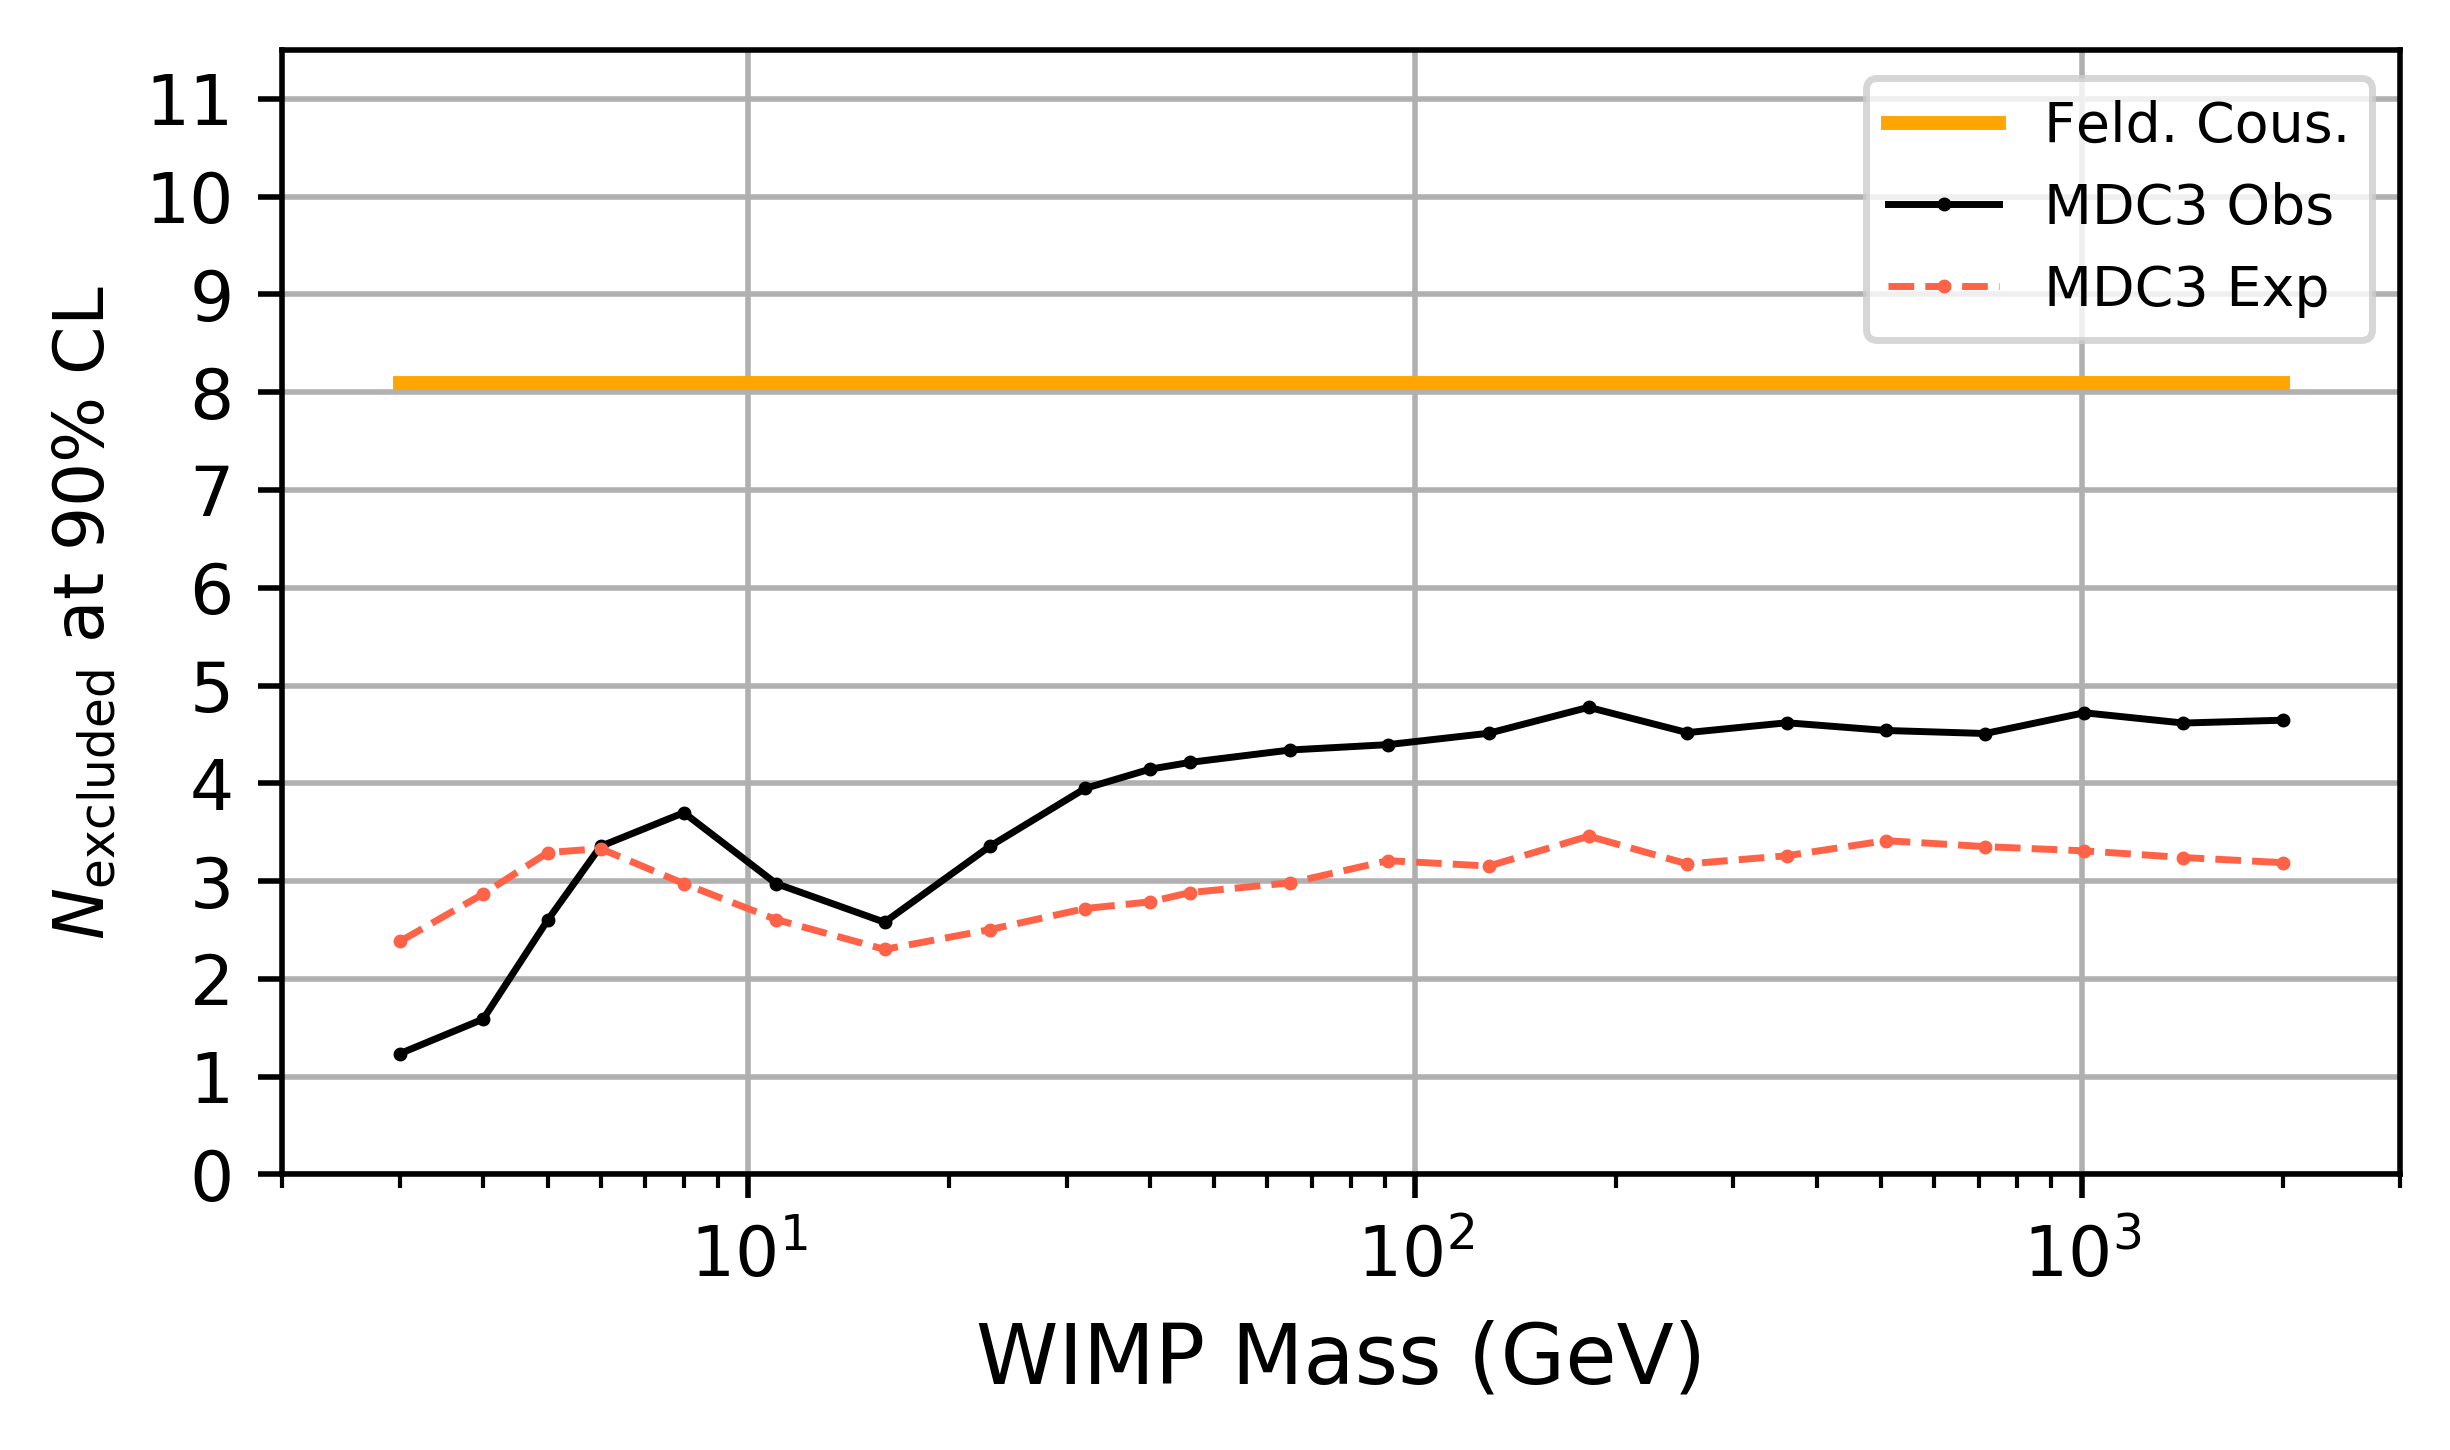

In [8]:
fig = plt.figure(figsize=(5,3),dpi=500)
ax = fig.gca()

plt.plot([nexcld[0,0],nexcld[-1,0]],[fc_nexcld,fc_nexcld],color='orange',linestyle='-',linewidth=2,label=r'Feld. Cous.')
plt.plot(nexcld[:,0],nexcld[:,1],color='black',marker='o',markersize=1,linestyle='-',linewidth=1,label='MDC3 Obs')
plt.plot(nexcld_exp[:,0],nexcld_exp[:,1],color='tomato',marker='o',markersize=1,linestyle='--',linewidth=1,label='MDC3 Exp')

ax.grid()
ax.set_xlabel(r'WIMP Mass (GeV)',fontsize=12)
ax.set_ylabel(r'$N_{\rm{excluded}}$ at 90% CL',fontsize=10)

xmin=2
xmax=3000
ymin=0
ymax=11.5
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
#ax.set_yscale('log')
plt.xscale('log')
ax.legend(loc='upper right',fontsize=8)
ax.yaxis.set_ticks(np.arange(ymin, ymax, 1))
plt.tight_layout()
plt.savefig('/Users/Scott/Downloads/nexcluded_mdc3.pdf')

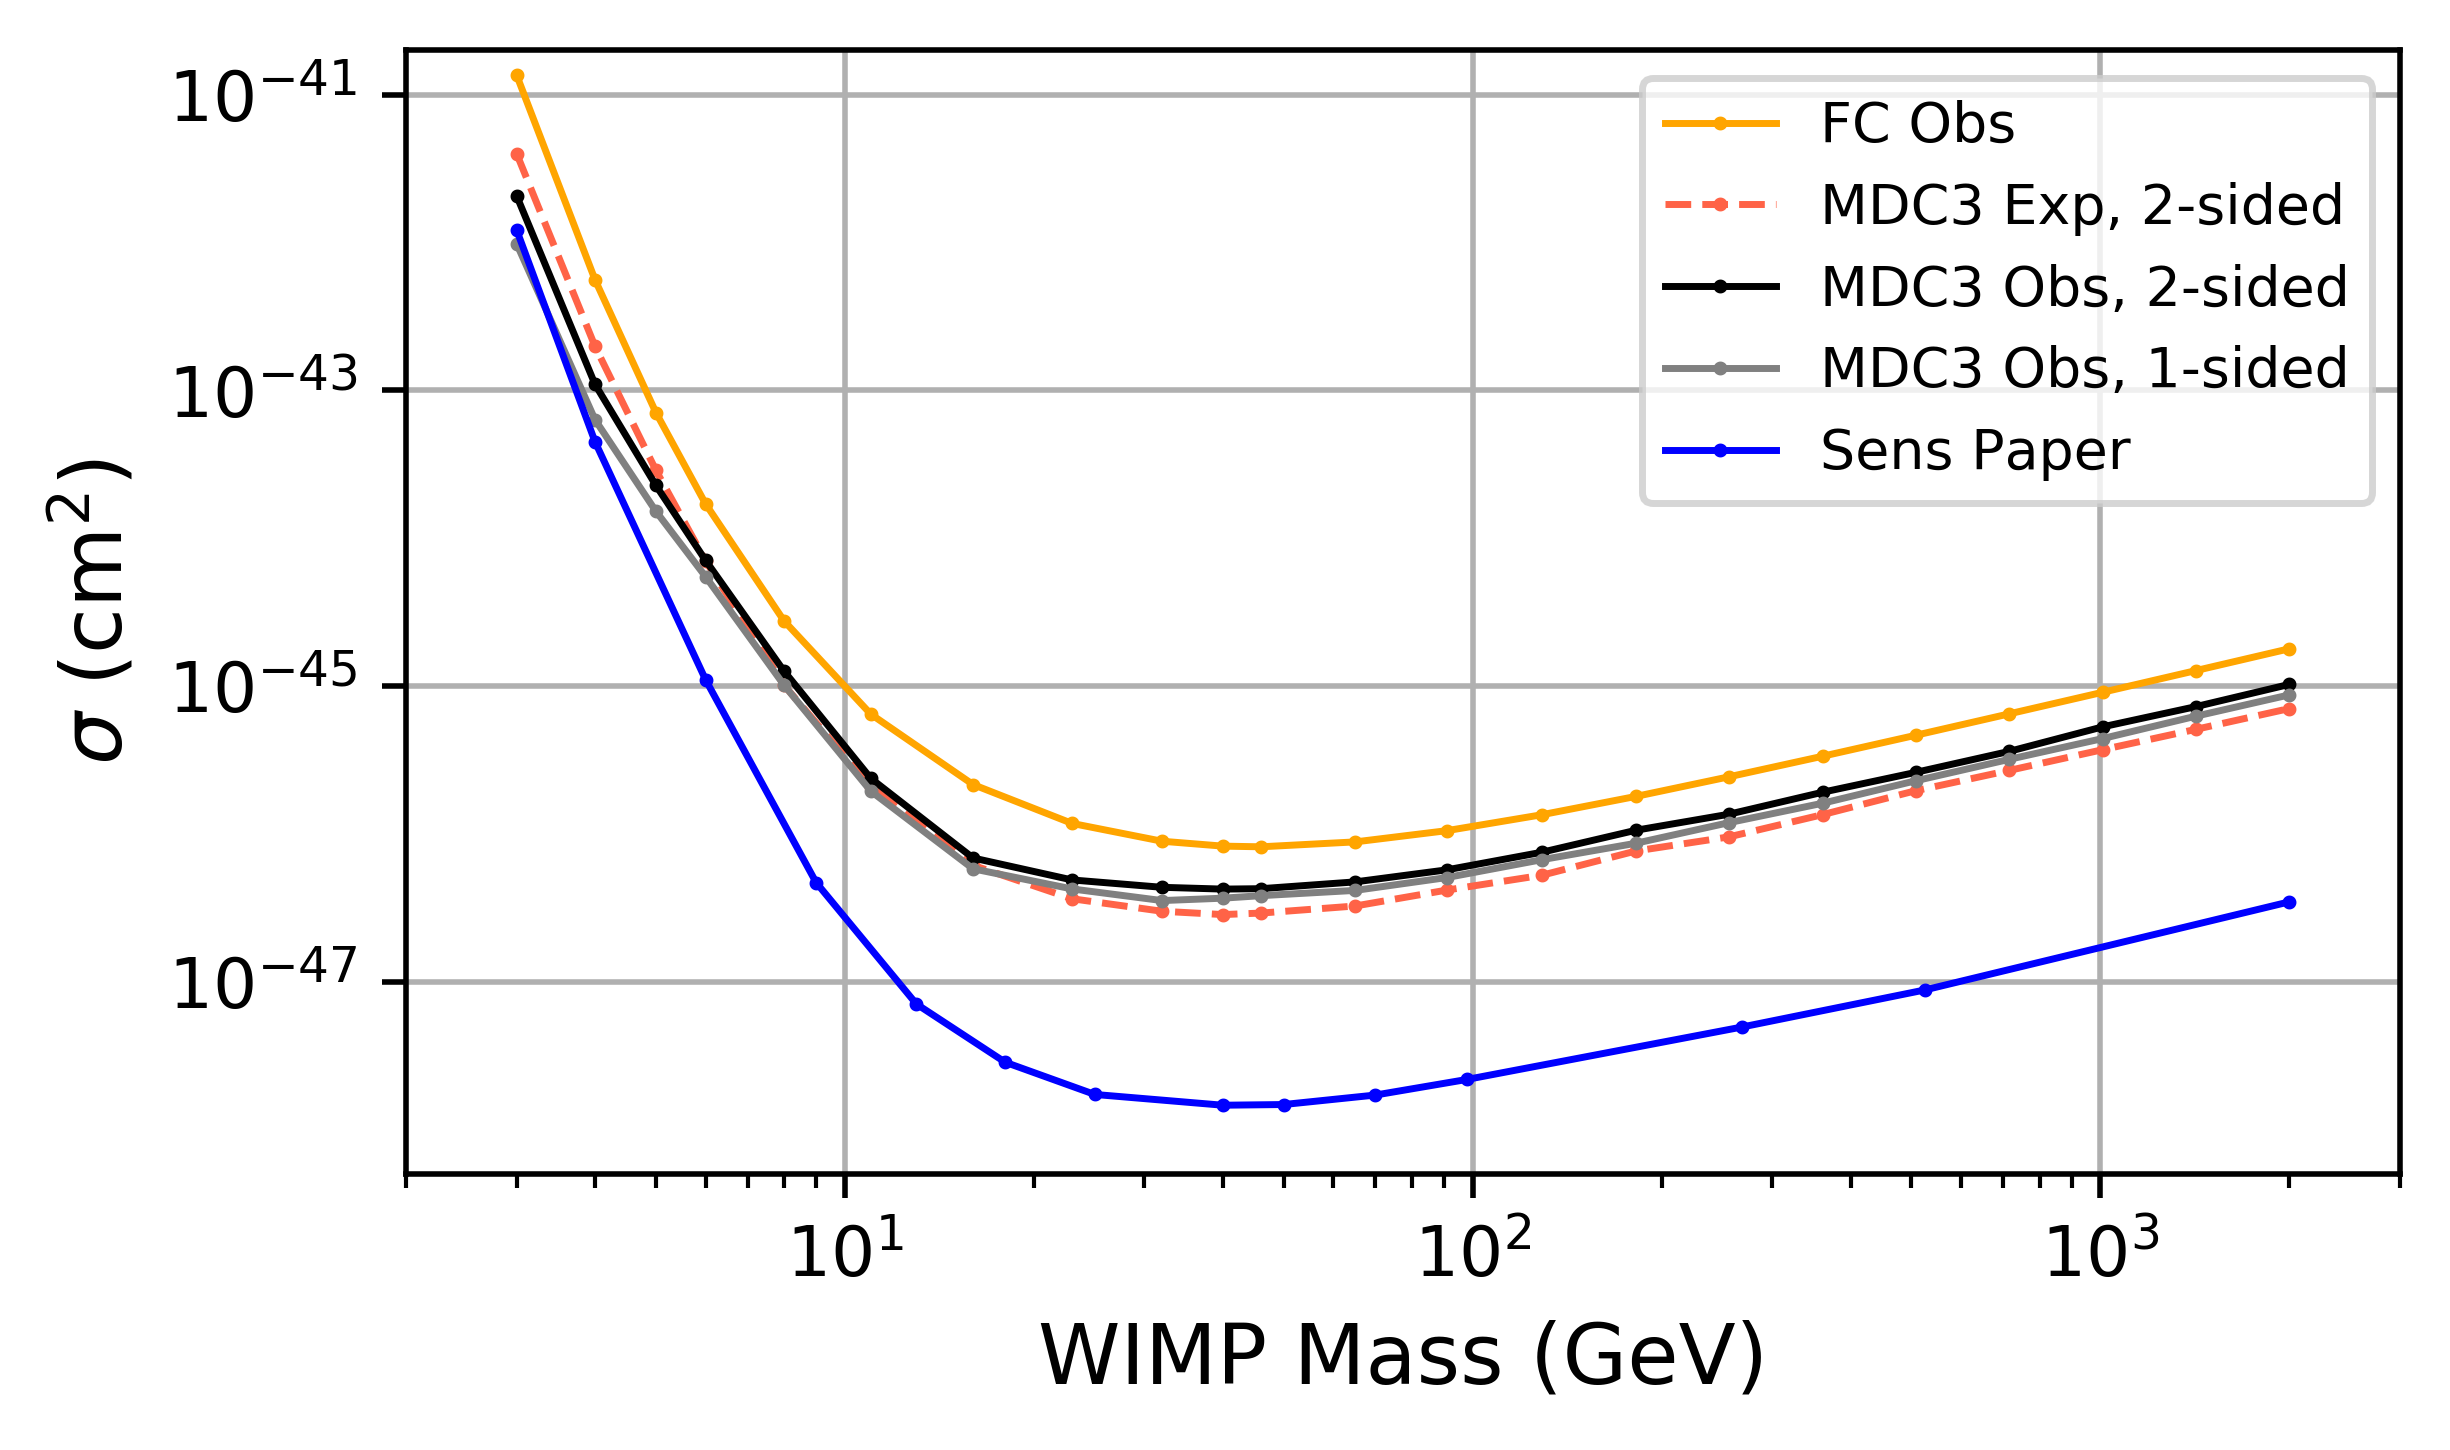

In [10]:
fig = plt.figure(figsize=(5,3),dpi=500)
ax = fig.gca()

plt.plot(fc[:,0],fc[:,1],color='orange',marker='o',markersize=1,linestyle='-',linewidth=1,label=r'FC Obs')



#plt.plot(new_masses,new_senspaper,color='steelblue',marker='o',markersize=1,linestyle='--',linewidth=1,label='Sens Paper Interp')

plt.plot(exp_mdc3[:,0],exp_mdc3[:,1],color='tomato',marker='o',markersize=1,linestyle='--',linewidth=1,label='MDC3 Exp, 2-sided')
plt.plot(obs_mdc3[:,0],obs_mdc3[:,1],color='black',marker='o',markersize=1,linestyle='-',linewidth=1,label='MDC3 Obs, 2-sided')

plt.plot(obs_mdc3_pos[:,0],obs_mdc3_pos[:,1],color='gray',marker='o',markersize=1,linestyle='-',linewidth=1,label=r'MDC3 Obs, 1-sided')
#plt.plot(exp_mdc3_pos[:,0],exp_mdc3_pos[:,1],color='salmon',marker='o',markersize=1,linestyle='--',linewidth=1,label=r'MDC3 Exp, $\mu>0$')

plt.plot(sens_paper[:,0],sens_paper[:,1],color='blue',marker='o',markersize=1,linestyle='-',linewidth=1,label='Sens Paper')

ax.grid()
ax.set_xlabel(r'WIMP Mass (GeV)',fontsize=12)
ax.set_ylabel(r'$\sigma$ (${\rm cm}^2$)',fontsize=12)

xmin=2
xmax=3000
ymin=5e-49
ymax=2e-41
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_yscale('log')
plt.xscale('log')
ax.legend(loc='upper right',fontsize=8)
plt.tight_layout()
#plt.savefig('/Users/Scott/Downloads/limit_comparison.pdf')

In [26]:
# compute ratios:

exp_ratio = np.zeros(np.shape(exp_mdc3))
obs_ratio = np.zeros(np.shape(exp_mdc3))
fc_ratio = np.zeros(np.shape(exp_mdc3))

# mass dimension:
exp_ratio[:,0] = np.copy( exp_mdc3[:,0] )
obs_ratio[:,0] = np.copy( exp_mdc3[:,0] )
fc_ratio[:,0] = np.copy( exp_mdc3[:,0] )

# ratio:
exp_ratio[:,1] = new_senspaper/exp_mdc3[:,1]
obs_ratio[:,1] = new_senspaper/obs_mdc3[:,1]
fc_ratio[:,1] = exp_mdc3[:,1]/fc[:,1]


In [17]:
# take ratio of S/sqrt(B) in low mass region

t_mdc3 = 24
t_s = 1000

#r_sig_mdc3 = 7e-4/24.
r_sig_mdc3 = 0.5/24.
r_bkg_mdc3 = 2.2/24.

#r_sig_s = 0.3e-4/24.
r_sig_s = 0.2/24.
r_bkg_s = 2.5*36./1000.

# q1 == S/sqrt(B)
q1_mdc3 = r_sig_mdc3*t_mdc3/np.sqrt(r_bkg_mdc3*t_mdc3)
q1_sens = r_sig_s*t_s/np.sqrt(r_bkg_s*t_s)

# q2 == S/sqrt(S+B)
q2_mdc3 = r_sig_mdc3*t_mdc3/np.sqrt(r_sig_mdc3*t_mdc3+r_bkg_mdc3*t_mdc3)
q2_sens = r_sig_s*t_s/np.sqrt(r_sig_s*t_s+r_bkg_s*t_s)

# q3 == (S+B)/sqrt(S+B)
q3_mdc3 = (r_sig_mdc3*t_mdc3+r_bkg_mdc3*t_mdc3)/np.sqrt(r_sig_mdc3*t_mdc3+r_bkg_mdc3*t_mdc3)
q3_sens = (r_sig_s*t_s+r_bkg_s*t_s)/np.sqrt(r_sig_s*t_s+r_bkg_s*t_s)

UL_ratio = ( q1_mdc3 / q1_sens )
UL_ratio2 = ( q2_mdc3 / q2_sens )
UL_ratio3 = ( q3_mdc3 / q3_sens )

#print(UL_ratio)

print('bkg cts:')
print('  mdc3: {:0.4f} evts'.format(r_bkg_mdc3*t_mdc3))
print('  sens: {:0.4f} evts'.format(r_bkg_s*t_mdc3))
print('sig cts:')
print('  mdc3: {:0.4f} evts'.format(r_sig_mdc3*t_mdc3))
print('  sens: {:0.4f} evts'.format(r_sig_s*t_mdc3))

print('Ratio of sens/mdc3: {:0.2f}'.format(UL_ratio))
print('Ratio of sens/mdc3 S/sqrt(S+B): {:0.2f}'.format(UL_ratio2))
print('Ratio of sens/mdc3 (S+B)/sqrt(S+B): {:0.2f}'.format(UL_ratio3))


#low_m_exp = np.zeros((5,2))
#low_m_exp[:,0] = np.copy( exp_mdc3[0:5,0] )
#low_m_exp[:,1] = UL_ratio

bkg cts:
  mdc3: 2.2000 evts
  sens: 2.1600 evts
sig cts:
  mdc3: 0.5000 evts
  sens: 0.2000 evts
Ratio of sens/mdc3: 0.38
Ratio of sens/mdc3 S/sqrt(S+B): 0.36
Ratio of sens/mdc3 (S+B)/sqrt(S+B): 0.17


In [18]:
# take ratio of S/sqrt(B) in high mass region, using 40 GeV WIMP

leakage = 1-0.995 # sens paper
sig_acc = 0.5 # 50% acceptance to use sens paper bkg rate

t_mdc3 = 24
t_s = 1000

r_sig_mdc3 = (97.7/24.) * sig_acc 
r_bkg_mdc3 = ((2/3)*231*leakage+2)/24.

r_sig_s = (90./24.) * sig_acc 
r_bkg_s = (5.7+36.*2.5)/1000. #sens paper give bkg rate after leakage directly

# q1 is S/sqrt(B)
q1_mdc3 = r_sig_mdc3*t_mdc3/np.sqrt(r_bkg_mdc3*t_mdc3)
q1_sens = r_sig_s*t_s/np.sqrt(r_bkg_s*t_s)

# q2 is S/sqrt(S+B)
q2_mdc3 = r_sig_mdc3*t_mdc3/np.sqrt(r_sig_mdc3*t_mdc3+r_bkg_mdc3*t_mdc3)
q2_sens = r_sig_s*t_s/np.sqrt(r_sig_s*t_s+r_bkg_s*t_s)

# q3 == (S+B)/sqrt(S+B)
q3_mdc3 = (r_sig_mdc3*t_mdc3+r_bkg_mdc3*t_mdc3)/np.sqrt(r_sig_mdc3*t_mdc3+r_bkg_mdc3*t_mdc3)
q3_sens = (r_sig_s*t_s+r_bkg_s*t_s)/np.sqrt(r_sig_s*t_s+r_bkg_s*t_s)

# ratio of these two:
UL_ratio_hm = ( q1_mdc3 / q1_sens )
UL_ratio2_hm = ( q2_mdc3 / q2_sens )
UL_ratio3_hm = ( q3_mdc3 / q3_sens )

print('bkg cts:')
print('  mdc3: {:0.4f} evts/d'.format(r_bkg_mdc3*t_mdc3))
print('  sens: {:0.4f} evts/d'.format(r_bkg_s*t_mdc3))
print('sig cts:')
print('  mdc3: {:0.4f} evts/d'.format(r_sig_mdc3*t_mdc3))
print('  sens: {:0.4f} evts/d'.format(r_sig_s*t_mdc3))

print('Ratio of sens/mdc3: {:0.2f}'.format(UL_ratio_hm))
print('Ratio of sens/mdc3 S/sqrt(S+B): {:0.2f}'.format(UL_ratio2_hm))
print('Ratio of sens/mdc3 (S+B)/sqrt(S+B): {:0.2f}'.format(UL_ratio3_hm))

#high_m_exp = np.zeros((n_masses-5,2))
#high_m_exp[:,0] = np.copy( exp_mdc3[5:n_masses,0] )
#high_m_exp[:,1] = UL_ratio_hm

bkg cts:
  mdc3: 2.7700 evts/d
  sens: 2.2968 evts/d
sig cts:
  mdc3: 48.8500 evts/d
  sens: 45.0000 evts/d
Ratio of sens/mdc3: 0.15
Ratio of sens/mdc3 S/sqrt(S+B): 0.16
Ratio of sens/mdc3 (S+B)/sqrt(S+B): 0.16


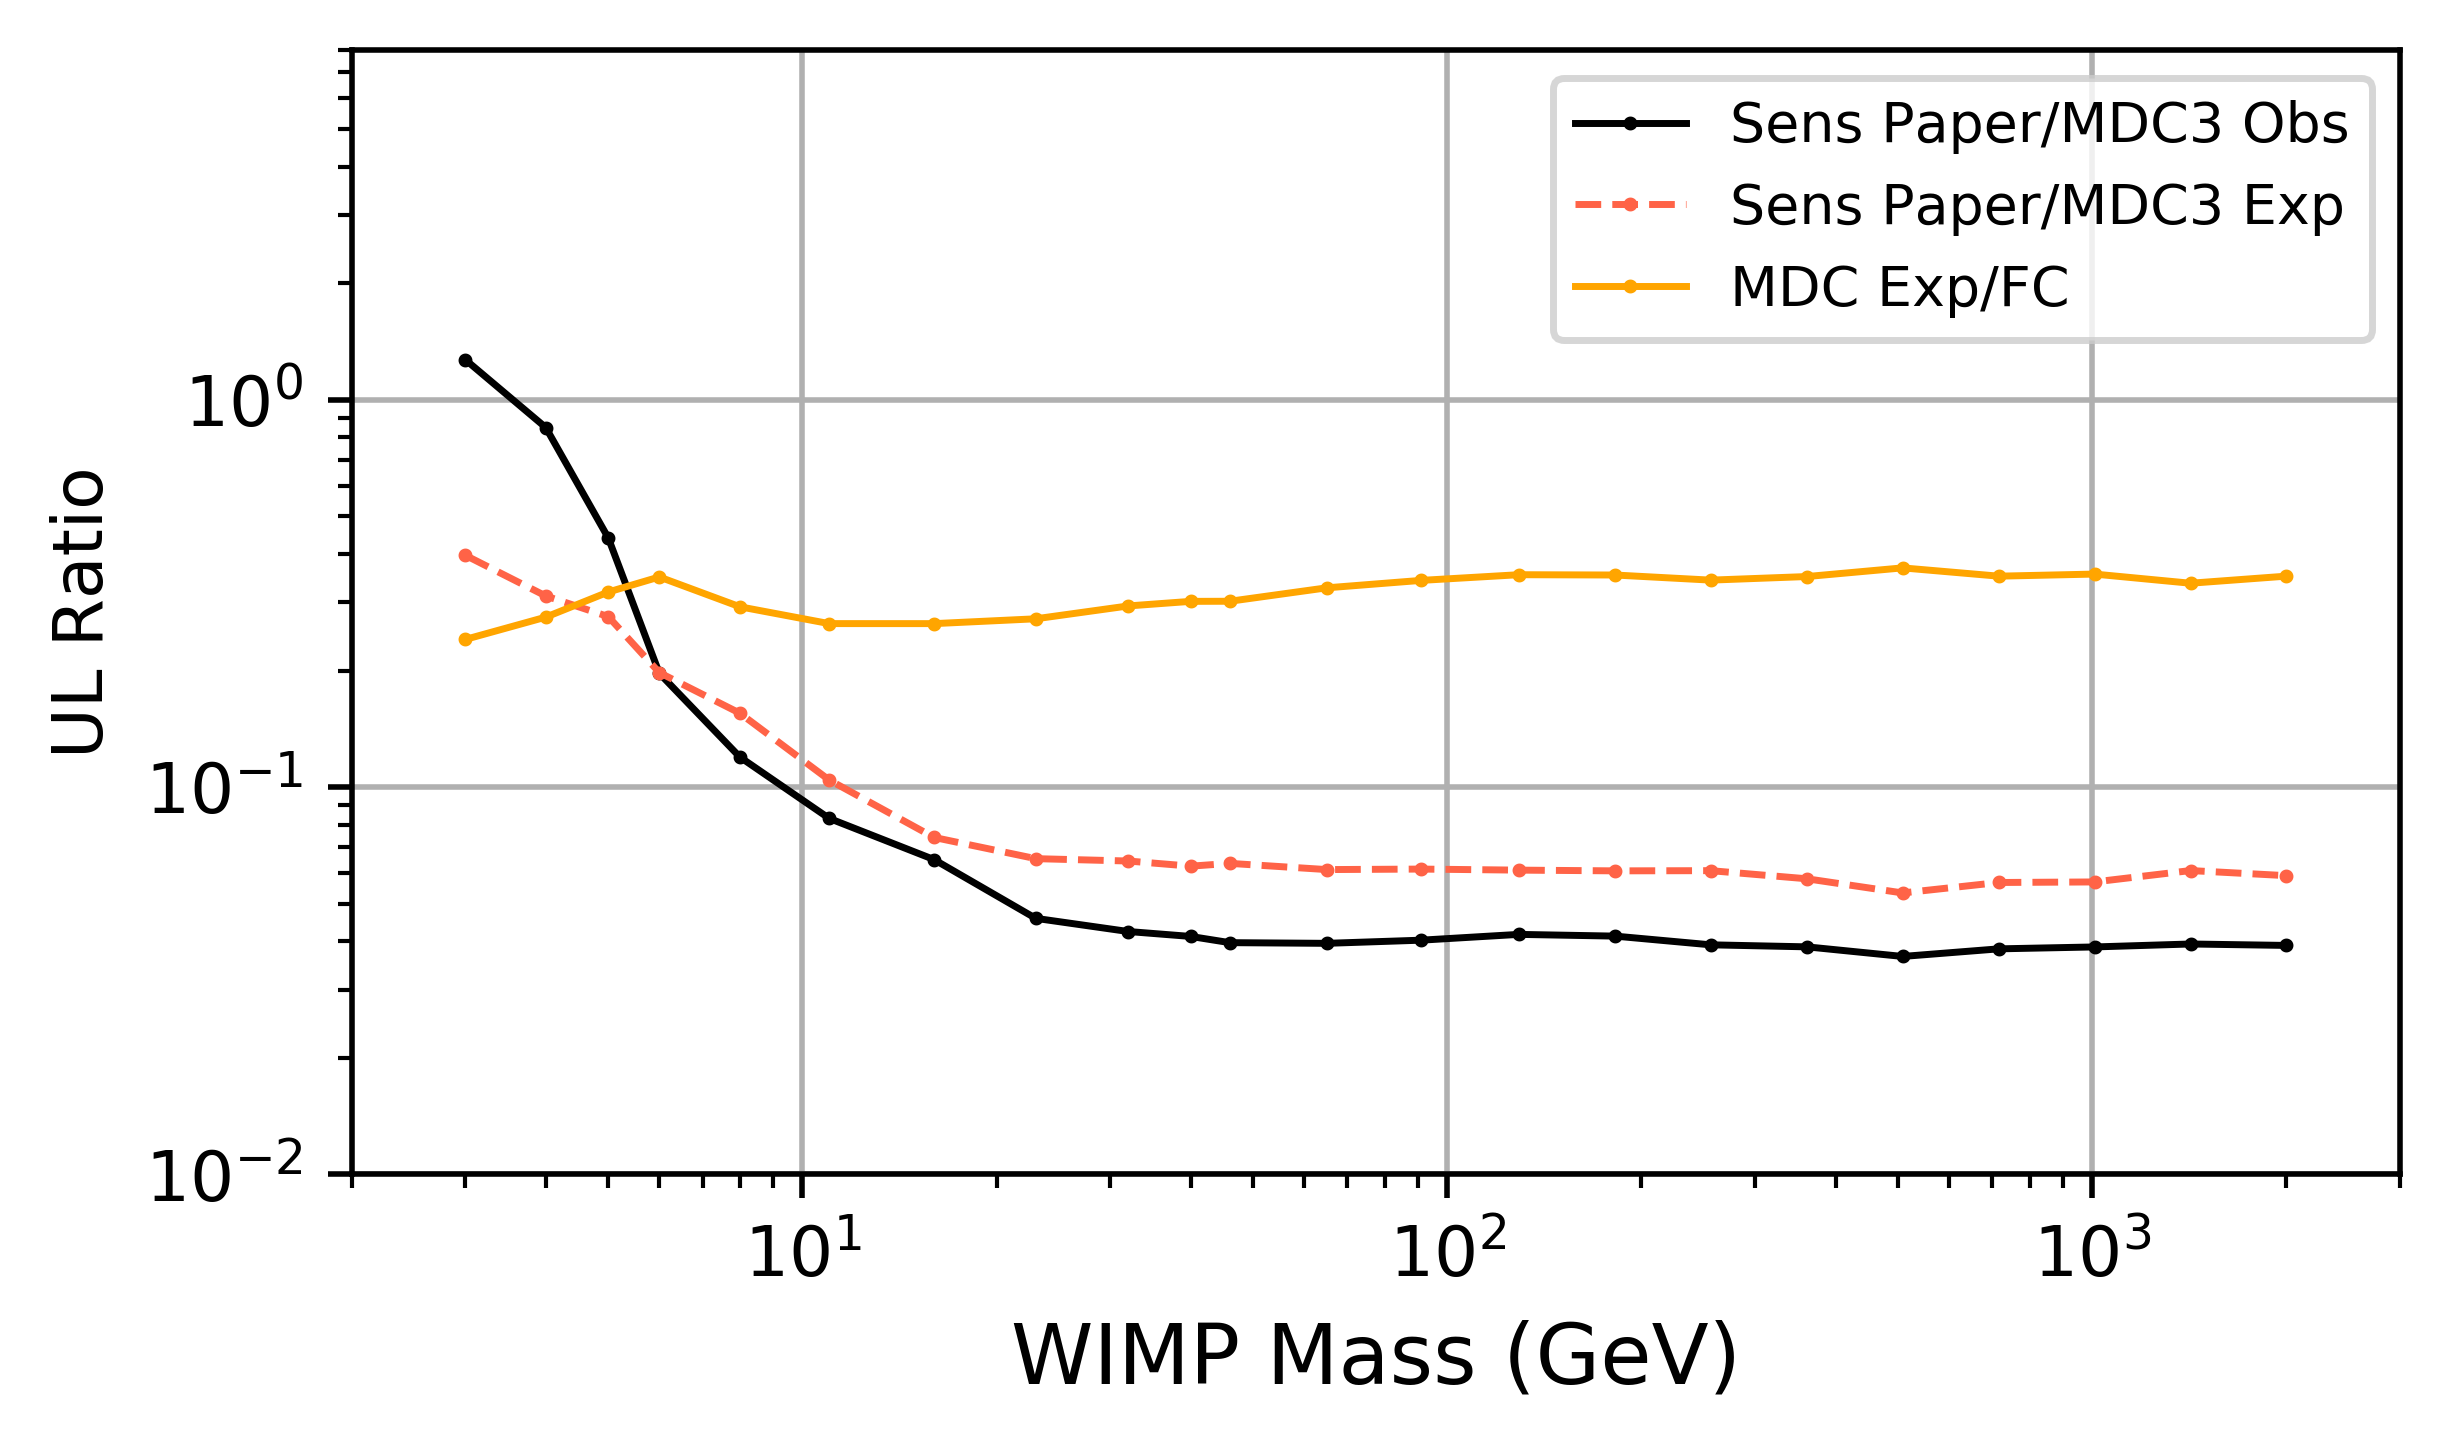

In [27]:
# plot ratio with sens paper

fig = plt.figure(figsize=(5,3),dpi=500)
ax = fig.gca()

#plt.plot(6,UL_ratio,color='forestgreen',marker='o',markersize=3,linestyle='none',label=r'$S/\sqrt{B}$ or $(S+B)/\sqrt{S+B}$ Exp')
#plt.plot(40,UL_ratio3_hm,color='forestgreen',marker='o',markersize=3)

plt.plot(obs_ratio[:,0],obs_ratio[:,1],color='black',marker='o',markersize=1,linestyle='-',linewidth=1,label='Sens Paper/MDC3 Obs')
plt.plot(exp_ratio[:,0],exp_ratio[:,1],color='tomato',marker='o',markersize=1,linestyle='--',linewidth=1,label='Sens Paper/MDC3 Exp')
plt.plot(fc_ratio[:,0],fc_ratio[:,1],color='orange',marker='o',markersize=1,linestyle='-',linewidth=1,label='MDC Exp/FC')

ax.grid()
ax.set_xlabel(r'WIMP Mass (GeV)',fontsize=12)
ax.set_ylabel('UL Ratio',fontsize=10)

xmin=2
xmax=3000
ymin=1e-2
ymax=8
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_yscale('log')
plt.xscale('log')
ax.legend(loc='upper right',fontsize=8)
plt.tight_layout()
#plt.savefig('/Users/Scott/Downloads/limit_comparison.pdf')

In [12]:
#min cross section:

print('min xsec is {:0.3e} cm^2 at {:0.1f} GeV'.format(np.amin(obs_mdc3[:,1]),obs_mdc3[np.argmin(obs_mdc3[:,1]),0]))

min xsec is 4.246e-47 cm^2 at 40.0 GeV


(22,)


In [25]:
ratio_3GeV = mdc3_exp[0,1]/sens_paper[0,1]
print(1/ratio_3GeV)

0.37661342130662684


0.44144038613664666


In [16]:
UL_ratio2 = ((r_sig_mdc3*t_mdc3+r_bkg_mdc3*t_mdc3)/np.sqrt(r_sig_mdc3*t_mdc3+r_bkg_mdc3*t_mdc3)) / ((r_sig_s*t_s+r_bkg_s*t_s)/np.sqrt(r_sig_s*t_s+r_bkg_s*t_s))
print(UL_ratio2)

0.15929291417453592


In [34]:
# load in best fit

bf_mu_sig = np.loadtxt('./best_fit_mu.txt',dtype=float,skiprows=1,usecols=(0,1))
bf_mu_b8 = np.loadtxt('./best_fit_mu.txt',dtype=float,skiprows=1,usecols=(0,2))

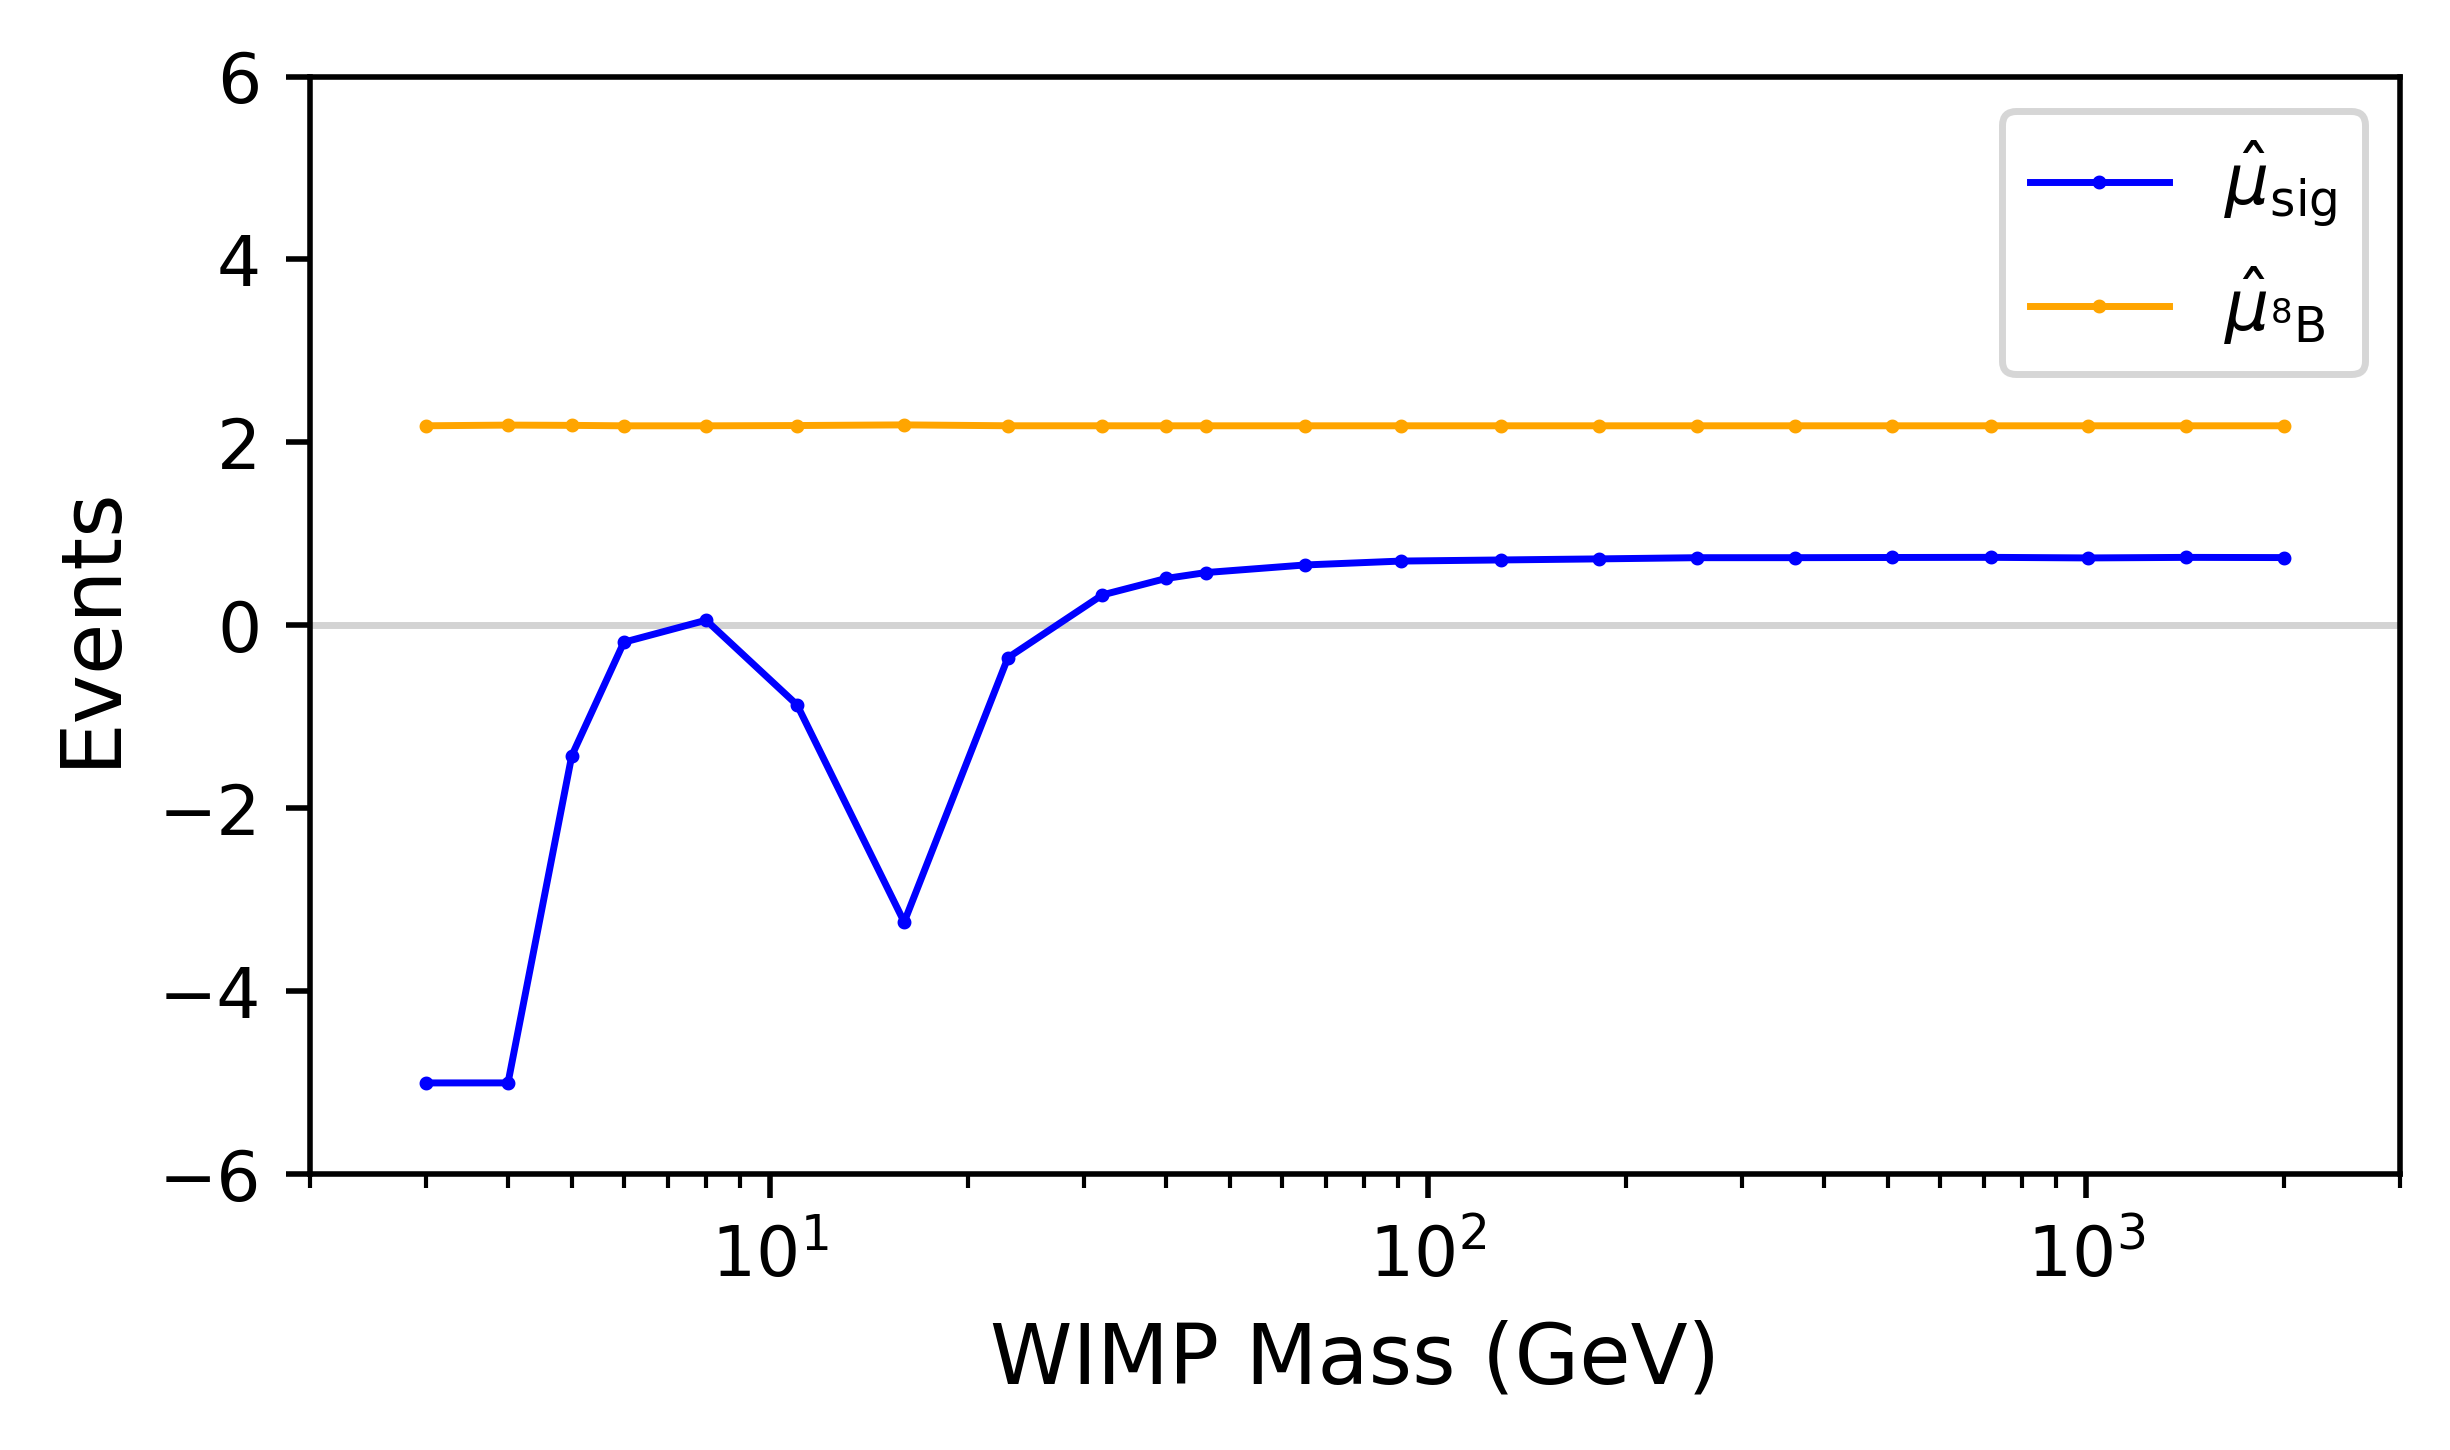

In [47]:
# plot as function of WIMP mass

fig = plt.figure(figsize=(5,3),dpi=500)
ax = fig.gca()

ax.axhline(0, linestyle='-',linewidth=1,color='lightgray') # horizontal lines

plt.plot(bf_mu_sig[:,0],bf_mu_sig[:,1],color='blue',marker='o',markersize=1,linestyle='-',linewidth=1,label=r'$\hat{\mu}_{\rm sig}$')
plt.plot(bf_mu_b8[:,0],bf_mu_b8[:,1],color='orange',marker='o',markersize=1,linestyle='-',linewidth=1,label=r'$\hat{\mu}_{\rm ^{8}B}$')


#ax.grid()
#ax.set_title(r'Cross Sections for $\nu+^{131}\mathrm{Xe} \to ^{131}\mathrm{Cs}^{*}+e^{-}$, $Q=355$ keV', fontsize=10)
ax.set_xlabel(r'WIMP Mass (GeV)',fontsize=12)
ax.set_ylabel('Events',fontsize=12)

xmin=2
xmax=3000
ymin=-6
ymax=6
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
#ax.set_yscale('log')
plt.xscale('log')
ax.legend(loc='upper right',fontsize=10)
plt.tight_layout()
#plt.savefig('/Users/Scott/Downloads/limit_comparison.pdf')

In [16]:
times = np.geomspace(1,2000,10)
scales = times/10.

for ii in range(len(times)):
    print('days = {:0.3f}, scale = {:0.3f}'.format(times[ii],scales[ii]))
#print(scales)

days = 1.000, scale = 0.100
days = 2.327, scale = 0.233
days = 5.415, scale = 0.541
days = 12.599, scale = 1.260
days = 29.317, scale = 2.932
days = 68.219, scale = 6.822
days = 158.740, scale = 15.874
days = 369.375, scale = 36.938
days = 859.506, scale = 85.951
days = 2000.000, scale = 200.000


In [14]:
print(scales)

[1.00000000e-01 2.32691817e-01 5.41454816e-01 1.25992105e+00
 2.93173318e+00 6.82190321e+00 1.58740105e+01 3.69375235e+01
 8.59505945e+01 2.00000000e+02]
